### Introduction

This notebook focuses on predicting drug-target binding affinity using Neural Networks, a critical task in computational drug discovery. By leveraging deep learning techniques, we aim to accurately estimate the binding strength between drugs and their target proteins, facilitating the identification of potential therapeutic compounds. The workflow includes data preprocessing, model training, evaluation, and performance visualization. This approach offers a scalable and efficient alternative to traditional experimental methods, accelerating the drug discovery pipeline.

### Import and Setup Packages 

In [2]:
!pip install rdkit

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 35.8 MB/s eta 0:00:00m eta 0:00:010:00:01


In [3]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import torch  # PyTorch library for tensor computations and neural networks
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F
import torch.optim as optim  # Optimization algorithms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader  # For handling datasets and data loading

In [4]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [5]:
colors = ["#A20025", "#6C8EBF", "#21130d"]
sns.set_palette(sns.color_palette(colors))

In [6]:
torch.__version__

'2.4.1+cu121'

In [7]:
torch.cuda.is_available()

False

In [9]:
# Set random seeds for deterministic resuluts
def seed(seed=121):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed()

## Ligand-based VS with PyTorch

###  First PyTorch Model

In [19]:
_bace_data= pd.read_csv("bace.csv")

In [20]:
_bace_data.head()

,mol,CID,Class,Model,pIC50,MW,AlogP,HBA,HBD,RB,...,PEOE6 (PEOE6),PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14),canvasUID
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901,431.56979,4.4014,3,2,5,...,53.205711,78.640335,226.85541,107.43491,37.133846,0.000000,7.980170,0.0,0.000000,1
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872,657.81073,2.6412,5,4,16,...,73.817162,47.171600,365.67694,174.07675,34.923889,7.980170,24.148668,0.0,24.663788,2
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970,591.74091,2.5499,4,3,11,...,70.365707,47.941147,192.40652,255.75255,23.654478,0.230159,15.879790,0.0,24.663788,3
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970,591.67828,3.1680,4,3,12,...,56.657166,37.954151,194.35304,202.76335,36.498634,0.980913,8.188327,0.0,26.385181,4
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970,629.71283,3.5086,3,3,11,...,78.945702,39.361153,179.71288,220.46130,23.654478,0.230159,15.879790,0.0,26.100143,5


In [21]:
_bace_data.columns

Index(['mol', 'CID', 'Class', 'Model', 'pIC50', 'MW', 'AlogP', 'HBA', 'HBD',
       'RB',
       ...
       'PEOE6 (PEOE6)', 'PEOE7 (PEOE7)', 'PEOE8 (PEOE8)', 'PEOE9 (PEOE9)',
       'PEOE10 (PEOE10)', 'PEOE11 (PEOE11)', 'PEOE12 (PEOE12)',
       'PEOE13 (PEOE13)', 'PEOE14 (PEOE14)', 'canvasUID'],
      dtype='object', length=595)

In [22]:
# Keep necessary columns
_bace_data = egfr_kinodata[["mol", "pIC50"]]
_bace_data.head(10)

,mol,pIC50
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,9.154901
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,8.853872
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,8.698970
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,8.698970
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,8.698970
5,S1(=O)C[C@@H](Cc2cc(OC(C(F)(F)F)C(F)(F)F)c(N)c...,8.698970
6,S(=O)(=O)(CCCCC)C[C@@H](NC(=O)c1cccnc1)C(=O)N[...,8.698970
7,Fc1c2c(ccc1)[C@@]([NH+]=C2N)(C=1C=C(C)C(=O)N(C...,8.612610
8,O1c2c(cc(cc2)CC)[C@@H]([NH2+]C[C@@H](O)[C@H]2N...,8.602060
9,O=C1N(CCCC1)C(C)(C)[C@@H]1C[C@@H](CCC1)C(=O)N[...,8.602060


In [23]:
_bace_data.describe()

,pIC50
count,1513.000000
mean,6.521991
std,1.342417
min,2.544546
25%,5.585027
50%,6.761954
75%,7.540000
max,10.522879


In [24]:
smiles, activities = _bace_data["mol"], _bace_data["pIC50"]

In [25]:
# Scaffold split
def scaffold_split(smiles, activities, test_size=0.2, random_state=42):
    mols, filtered_smiles = [], []
    for s in smiles:
        try:
            mols.append(Chem.MolFromSmiles(s))
            filtered_smiles.append(s)
        except:
            continue

    scaffolds = {}
    for i, mol in enumerate(mols):
        scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=True)
        if scaffold not in scaffolds:
            scaffolds[scaffold] = [i]
        else:
            scaffolds[scaffold].append(i)
    
    scaffold_sets = list(scaffolds.values())
    train_idx, test_idx = train_test_split(scaffold_sets, test_size=test_size, random_state=random_state)
    
    train_idx = [idx for set_idx in train_idx for idx in set_idx]
    test_idx = [idx for set_idx in test_idx for idx in set_idx]
    
    return [filtered_smiles[i] for i in train_idx], [activities[i] for i in train_idx], \
           [filtered_smiles[i] for i in test_idx], [activities[i] for i in test_idx]

train_smiles, train_activities, test_smiles, test_activities = scaffold_split(smiles, activities)

In [27]:
print(len(train_smiles))
print(len(test_smiles))

1234
279


In [28]:
train_smiles, val_smiles, train_activities, val_activities = train_test_split(
        train_smiles, train_activities, test_size=0.1, random_state=101)

In [29]:
# Feature extraction
def smiles_to_fp(smiles, fp_size=2048):
    mol = Chem.MolFromSmiles(smiles)
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=fp_size)
    return np.array(mfpgen.GetFingerprint(mol))

# Dataset class
class MoleculeDataset(Dataset):
    def __init__(self, smiles, activities):
        self.smiles = smiles
        self.activities = activities
        self.fingerprints = [smiles_to_fp(s) for s in smiles]
        
    def __len__(self):
        return len(self.smiles)
    
    def __getitem__(self, idx):
        fp = torch.tensor(self.fingerprints[idx], dtype=torch.float32)
        activity = torch.tensor([self.activities[idx]], dtype=torch.float32)
        return fp, activity

# Create datasets and dataloaders
train_dataset = MoleculeDataset(train_smiles, train_activities)
val_dataset = MoleculeDataset(val_smiles, val_activities)
test_dataset = MoleculeDataset(test_smiles, test_activities)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [69]:
# Neural Network model
class _sar_nn(nn.Module):
    def __init__(self, input_size=2048):
        super(_sar_nn, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = _sar_nn().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

/N/u/abseal/Quartz/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [70]:
print(model)

_sar_nn(
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [76]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print("=================================")

print(list(model.parameters())[0])
print("=================================")
print(list(model.parameters())[0].shape)

1213441
Parameter containing:
tensor([[-0.0090,  0.0080, -0.0106,  ...,  0.0211,  0.0161, -0.0079],
        [ 0.0105, -0.0079,  0.0183,  ..., -0.0017, -0.0057,  0.0189],
        [ 0.0123,  0.0194, -0.0038,  ..., -0.0143, -0.0024, -0.0188],
        ...,
        [-0.0148,  0.0093, -0.0062,  ..., -0.0201, -0.0015,  0.0030],
        [-0.0018, -0.0028, -0.0163,  ..., -0.0050, -0.0161, -0.0206],
        [ 0.0172,  0.0135,  0.0114,  ..., -0.0148,  0.0156, -0.0106]],
       requires_grad=True)
torch.Size([512, 2048])


In [77]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    model.train()
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Learning rate scheduler step
        scheduler.step(val_loss)
        
        model.train()
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, num_epochs+1), y=train_losses, label='Train Loss')
    sns.lineplot(x=range(1, num_epochs+1), y=val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_curves_sns.png', bbox_inches='tight', dpi=600)
    plt.savefig('loss_curves_sns.pdf', bbox_inches='tight', dpi=600);
    plt.close()

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=100)

Epoch 1/100, Train Loss: 14.1207, Val Loss: 2.3467
Epoch 2/100, Train Loss: 1.4416, Val Loss: 0.8694
Epoch 3/100, Train Loss: 0.9326, Val Loss: 0.8525
Epoch 4/100, Train Loss: 0.8310, Val Loss: 0.5759
Epoch 5/100, Train Loss: 0.6784, Val Loss: 0.5732
Epoch 6/100, Train Loss: 0.6396, Val Loss: 0.6659
Epoch 7/100, Train Loss: 0.5487, Val Loss: 0.7529
Epoch 8/100, Train Loss: 0.5714, Val Loss: 0.5421
Epoch 9/100, Train Loss: 0.5232, Val Loss: 0.6253
Epoch 10/100, Train Loss: 0.5412, Val Loss: 0.6938
Epoch 11/100, Train Loss: 0.5994, Val Loss: 0.6602
Epoch 12/100, Train Loss: 0.6896, Val Loss: 0.6147
Epoch 13/100, Train Loss: 0.4395, Val Loss: 0.8329
Epoch 14/100, Train Loss: 0.5491, Val Loss: 0.8329
Epoch 15/100, Train Loss: 0.4944, Val Loss: 0.6129
Epoch 16/100, Train Loss: 0.4286, Val Loss: 0.7893
Epoch 17/100, Train Loss: 0.3910, Val Loss: 0.6554
Epoch 18/100, Train Loss: 0.3540, Val Loss: 0.5647
Epoch 19/100, Train Loss: 0.3747, Val Loss: 0.5653
Epoch 20/100, Train Loss: 0.3681, Val L

2025-01-14 15:44:09,415 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss: 0.7709
Mean Squared Error: 0.7622
Mean Absolute Error: 0.6555
R-squared: 0.6078


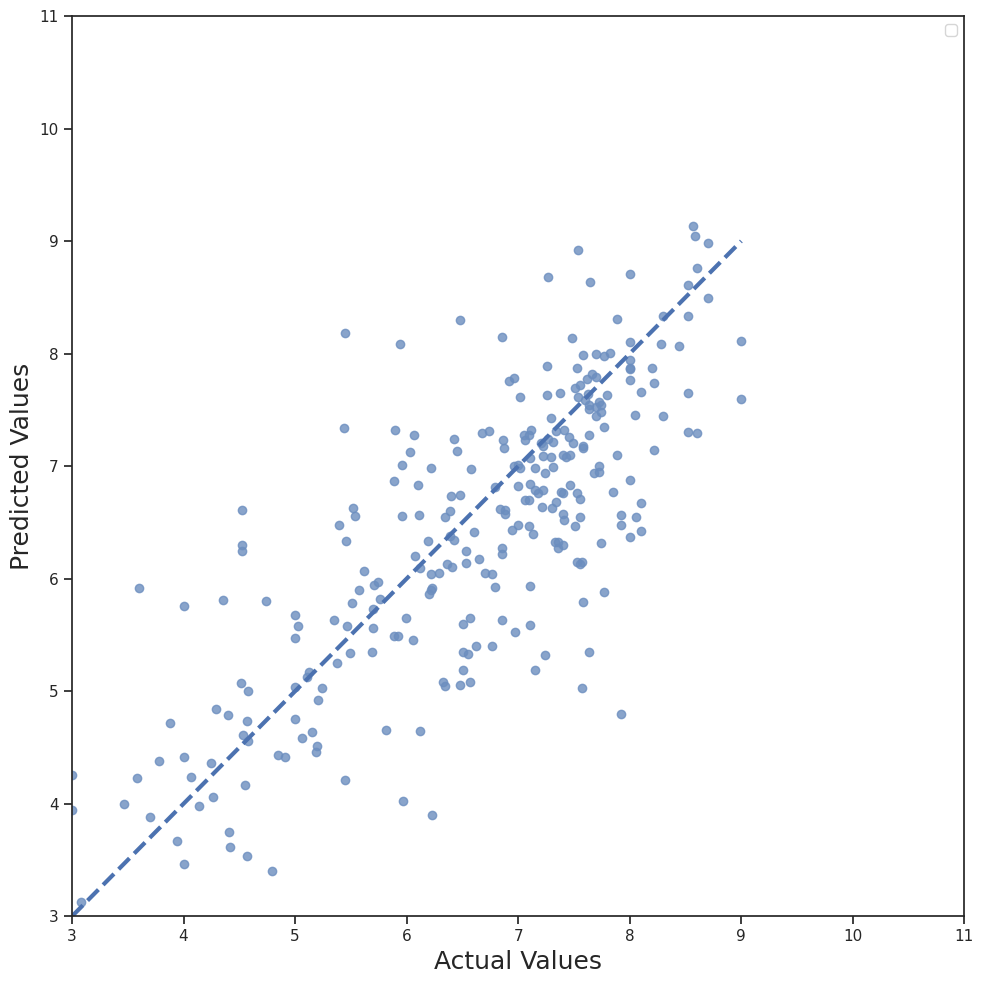

In [78]:
# Evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()
    
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    r2 = np.corrcoef(predictions, actuals)[0, 1]**2
    
    print(f'Test Loss: {total_loss/len(test_loader):.4f}')
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'R-squared: {r2:.4f}')

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.scatter(actuals, predictions, alpha=0.8, color="#6C8EBF")
    ax.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], '--', lw=3)
    ax.set_xlabel("Actual Values", fontsize=18)
    ax.set_ylabel("Predicted Values", fontsize=18)
    ax.set_xlim([3, 11])
    ax.set_ylim([3, 11])
    ax.legend(loc="best")
    plt.tight_layout()
    plt.savefig('bvs_scatter.png', bbox_inches='tight', dpi=600)
    plt.savefig('lbvs_scatter.pdf', bbox_inches='tight', dpi=600);

evaluate_model(model, test_loader, criterion, device)

In [80]:
# Save the trained model
torch.save(model.state_dict(), 'bace_model.pth')
print("Model saved successfully.")

Model saved successfully.


In [60]:
loaded_model = _sar_nn()
loaded_model.load_state_dict(torch.load('bace_model.pth'))
loaded_model.eval()  # Set the model to evaluation mode

/tmp/ipykernel_3593624/2066391550.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('bace_model.pth'))


KinaseBinderNN(
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

### Enrichment Factors in Virtual Screening

In [61]:
def evaluate_model_enrichment(model, test_loader, criterion, device, activity_threshold=6.3):
    model.eval()
    total_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()
    
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    r2 = np.corrcoef(predictions, actuals)[0, 1]**2
    
    logger.info(f'Test Loss: {total_loss/len(test_loader):.4f}')
    logger.info(f'Mean Squared Error: {mse:.4f}')
    logger.info(f'Mean Absolute Error: {mae:.4f}')
    logger.info(f'R-squared: {r2:.4f}')

    return predictions, actuals

2025-01-14 15:37:24,298 - INFO - Test Loss: 0.7613
2025-01-14 15:37:24,300 - INFO - Mean Squared Error: 0.7542
2025-01-14 15:37:24,301 - INFO - Mean Absolute Error: 0.6609
2025-01-14 15:37:24,308 - INFO - R-squared: 0.6162


Enrichment Factors:
EF0.5%:
  Model:  1.52
  Optimal: 1.52
  Random:  1.00
EF1.0%:
  Model:  1.52
  Optimal: 1.52
  Random:  1.00
EF2.0%:
  Model:  1.52
  Optimal: 1.52
  Random:  1.00
EF5.0%:
  Model:  1.52
  Optimal: 1.52
  Random:  1.00
EF50.0%:
  Model:  1.40
  Optimal: 1.52
  Random:  1.00
Found actives (%) for top 5% of ranked data set:
  Model:  7.62
  Optimal:  7.62
  Random:  5.00


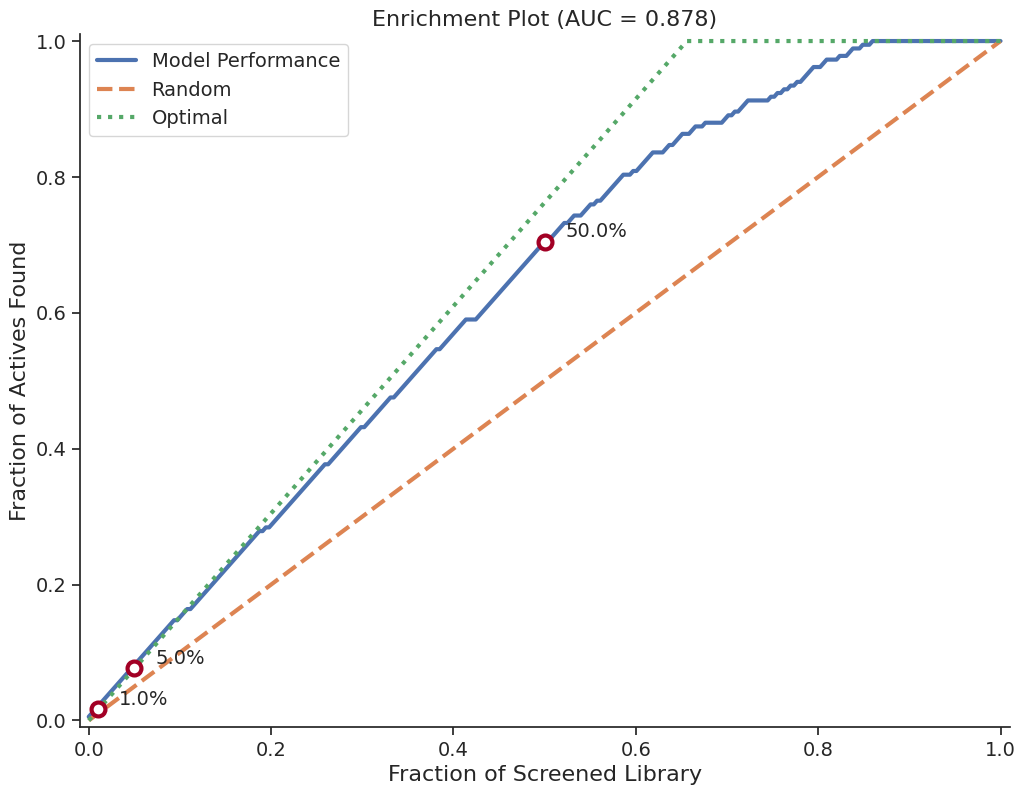

In [67]:
from sklearn.metrics import roc_curve, auc

def create_enrichment_plot(y_true, y_pred, activity_threshold=6.3, ef_percentages=[0.005, 0.01, 0.02, 0.05]):
    # Convert continuous predictions to binary (active/inactive)
    y_true_binary = (y_true >= activity_threshold).astype(int)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Calculate enrichment curve
    sorted_indices = np.argsort(y_pred)[::-1]
    n_actives = np.sum(y_true_binary)
    n_total = len(y_true_binary)
    
    x_values = np.linspace(0, 1, n_total)
    y_values = np.cumsum(y_true_binary[sorted_indices]) / n_actives
    
    # Set up the plot style
    sns.set_style("ticks")
    plt.figure(figsize=(12, 9))
    
    # Plot enrichment curve
    sns.lineplot(x=x_values, y=y_values, label='Model Performance', linewidth=3)
    sns.lineplot(x=[0, 1], y=[0, 1], label='Random', linestyle='--', linewidth=3)
    sns.lineplot(x=[0, n_actives/n_total, 1], y=[0, 1, 1], label='Optimal', linestyle=':', linewidth=3)
    sns.despine()

    # Add dots for EF percentages
    for percentage in ef_percentages:
        index = int(n_total * percentage)
        plt.plot(percentage, y_values[index], 'o', markersize=10, 
                 markerfacecolor='white', markeredgecolor='#A20025', markeredgewidth=3)
        plt.annotate(f'{percentage*100:.1f}%', (percentage, y_values[index]), 
                     xytext=(15, 3), textcoords='offset points', fontsize=14)
    
    plt.xlabel('Fraction of Screened Library', fontsize=16)
    plt.ylabel('Fraction of Actives Found', fontsize=16)
    plt.title(f'Enrichment Plot (AUC = {roc_auc:.3f})', fontsize=16)
    plt.legend(fontsize=14)
    
    # Adjust plot limits and ticks
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('enrichment_plot.png', bbox_inches='tight', dpi=600)
    plt.savefig('enrichment_plot.pdf', bbox_inches='tight', dpi=600)
    return plt

def calculate_enrichment_factors(y_true, y_pred, activity_threshold=6.3, ef_percentages=[0.005, 0.01, 0.02, 0.05]):
    y_true_binary = (y_true >= activity_threshold).astype(int)
    sorted_indices = np.argsort(y_pred)[::-1]
    n_actives = np.sum(y_true_binary)
    n_total = len(y_true_binary)
    
    enrichment_factors = {}
    for percentage in ef_percentages:
        n_compounds = int(n_total * percentage)

        # Model performance
        n_actives_found = np.sum(y_true_binary[sorted_indices[:n_compounds]])
        ef_model = (n_actives_found / n_compounds) / (n_actives / n_total)
        
        # Optimal performance (all actives at the top)
        ef_optimal = min(1 / percentage, n_total / n_actives)
        
        # Random performance
        ef_random = 1.0  # By definition, random selection has an enrichment factor of 1
        
        enrichment_factors[f"EF{percentage*100:.1f}%"] = {
            "Model": ef_model,
            "Optimal": ef_optimal,
            "Random": ef_random
        }
    
    return enrichment_factors

predictions, actuals = evaluate_model_enrichment(loaded_model, test_loader, criterion, device)

# Calculate and print enrichment factors
ef_percentages=[0.005, 0.01, 0.02, 0.05, 0.5]
ef = calculate_enrichment_factors(actuals, predictions, ef_percentages=ef_percentages)

# Create and show enrichment plot
plt = create_enrichment_plot(actuals, predictions, ef_percentages=[0.01, 0.05, 0.5])

print("Enrichment Factors:")
for k, v in ef.items():
    print(f"{k}:")
    print(f"  Model:  {v['Model']:.2f}")
    print(f"  Optimal: {v['Optimal']:.2f}")
    print(f"  Random:  {v['Random']:.2f}")

print("Found actives (%) for top 5% of ranked data set:")
for k, v in ef["EF5.0%"].items():
    print(f"  {k}:  {v * 5:.2f}")

In [65]:
ef

{'EF0.5%': {'Model': 1.5245901639344264,
  'Optimal': 1.5245901639344261,
  'Random': 1.0},
 'EF1.0%': {'Model': 1.5245901639344264,
  'Optimal': 1.5245901639344261,
  'Random': 1.0},
 'EF2.0%': {'Model': 1.5245901639344264,
  'Optimal': 1.5245901639344261,
  'Random': 1.0},
 'EF5.0%': {'Model': 1.5245901639344264,
  'Optimal': 1.5245901639344261,
  'Random': 1.0},
 'EF50.0%': {'Model': 1.4039391437669537,
  'Optimal': 1.5245901639344261,
  'Random': 1.0}}